# Financial Inclusion Prediction

The objective of this competition is to create a machine learning model to predict which individuals are most likely to have or use a bank account. The models and solutions developed can provide an indication of the state of financial inclusion in Kenya, Rwanda, Tanzania and Uganda, while providing insights into some of the key factors driving individuals’ financial security.


The evaluation metric for this challenge is Mean Absolute error, where 1 indicates that the individual does have a bank account and 0 indicates that they do not.

Your submission file should look like:

* unique_id                   bank_account
* uniqueid_1 x Kenya              1
* uniqueid_2 x Kenya              0
* uniqueid_3 x Kenya              1  

### Import and load the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from joblib import Parallel, delayed
import joblib

%matplotlib inline

/Users/munge/.virtual-envs/ml-venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
finance_df = pd.read_csv('datasets/financial_inclusion_dataset.csv')
finance_df.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


#### Encoding categorical data

In [3]:
finance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


In [4]:
finance_df.duplicated().sum()

np.int64(0)

In [5]:
finance_df.isnull().sum()

country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

In [6]:
finance_df.shape

(23524, 13)

In [7]:
finance_df.describe(include='all')

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
count,23524,23524.000000,23524,23524,23524,23524,23524.000000,23524.000000,23524,23524,23524,23524,23524
unique,4,NaN,8735,2,2,2,NaN,NaN,2,6,5,6,10
top,Rwanda,NaN,uniqueid_1,No,Rural,Yes,NaN,NaN,Female,Head of Household,Married/Living together,Primary education,Self employed
freq,8735,NaN,4,20212,14343,17454,NaN,NaN,13877,12831,10749,12791,6437
mean,NaN,2016.975939,NaN,NaN,NaN,NaN,3.797483,38.805220,NaN,NaN,NaN,NaN,NaN
std,NaN,0.847371,NaN,NaN,NaN,NaN,2.227613,16.520569,NaN,NaN,NaN,NaN,NaN
min,NaN,2016.000000,NaN,NaN,NaN,NaN,1.000000,16.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,2016.000000,NaN,NaN,NaN,NaN,2.000000,26.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,2017.000000,NaN,NaN,NaN,NaN,3.000000,35.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,2018.000000,NaN,NaN,NaN,NaN,5.000000,49.000000,NaN,NaN,NaN,NaN,NaN


#### Create a ydata profile report

In [8]:
profile = ProfileReport(finance_df, title='Financial Inclusion in East Africa Report')

In [9]:
#profile.to_file(output_file='profile-report.html')

#### Analysis

The dataframe has 23524 values with 13 columns. There are neither missing values nor duplicates in the dataset. Most of the data in the dataset is categorical so we'll need to encode the data to prepare it for the machine learning model

#### Explarotory Data Analysis

In [10]:
finance_df.tail()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
23519,Uganda,2018,uniqueid_2113,No,Rural,Yes,4,48,Female,Head of Household,Divorced/Seperated,No formal education,Other Income
23520,Uganda,2018,uniqueid_2114,No,Rural,Yes,2,27,Female,Head of Household,Single/Never Married,Secondary education,Other Income
23521,Uganda,2018,uniqueid_2115,No,Rural,Yes,5,27,Female,Parent,Widowed,Primary education,Other Income
23522,Uganda,2018,uniqueid_2116,No,Urban,Yes,7,30,Female,Parent,Divorced/Seperated,Secondary education,Self employed
23523,Uganda,2018,uniqueid_2117,No,Rural,Yes,10,20,Male,Child,Single/Never Married,Secondary education,No Income


#### No. of people with bank accounts per country

In [11]:
country_bank_accounts = finance_df[finance_df['bank_account'] == 'Yes'].groupby(['country'])['bank_account'].value_counts().sort_values().reset_index()
country_bank_accounts

,country,bank_account,count
0,Uganda,Yes,181
1,Tanzania,Yes,607
2,Rwanda,Yes,1003
3,Kenya,Yes,1521


#### No. of people with bank accounts per location type

In [12]:
location_bank_accounts = finance_df[finance_df['bank_account'] == 'Yes'].groupby(['location_type'])['bank_account'].value_counts().sort_values().reset_index()
location_bank_accounts

,location_type,bank_account,count
0,Urban,Yes,1641
1,Rural,Yes,1671


#### No. of people with bank accounts per gender

In [13]:
gender_bank_accounts = finance_df[finance_df.bank_account == 'Yes'].groupby(['gender_of_respondent'])['gender_of_respondent'].value_counts().sort_values().reset_index()
gender_bank_accounts

,gender_of_respondent,count
0,Female,1482
1,Male,1830


#### No. of bank accounts per education level

In [14]:
education_bank_accounts = finance_df[finance_df.bank_account == 'Yes'].groupby(['education_level'])['education_level'].value_counts().sort_values().reset_index()
education_bank_accounts

,education_level,count
0,Other/Dont know/RTA,11
1,No formal education,176
2,Vocational/Specialised training,458
3,Tertiary education,591
4,Secondary education,983
5,Primary education,1093


#### No. of bank accounts per marital status

In [15]:
marital_status_bank_accounts = finance_df[finance_df.bank_account == 'Yes'].groupby(['marital_status'])['marital_status'].value_counts().sort_values().reset_index()
marital_status_bank_accounts

,marital_status,count
0,Dont know,2
1,Divorced/Seperated,234
2,Widowed,244
3,Single/Never Married,966
4,Married/Living together,1866


#### No. of bank accounts per job type

In [16]:
job_status_bank_accounts = finance_df[finance_df.bank_account == 'Yes'].groupby(['job_type'])['job_type'].value_counts().sort_values().reset_index()
job_status_bank_accounts

,job_type,count
0,No Income,13
1,Dont Know/Refuse to answer,14
2,Government Dependent,50
3,Other Income,196
4,Remittance Dependent,240
5,Formally employed Government,300
6,Informally employed,445
7,Formally employed Private,571
8,Farming and Fishing,635
9,Self employed,848


#### Feature Engineering

In [17]:
#Convert year to date type
finance_df['year'] = pd.to_datetime(finance_df['year'], format='%Y')

In [18]:
finance_df['year'] = finance_df.year.dt.year

In [19]:
finance_df.year.dtype

dtype('int32')

### Encoding Categorical Columns

In [20]:
finance_df.head(1)

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed


In [21]:
categorical_cols = ['country','location_type','year', 
                    'relationship_with_head', 'marital_status', 
                    'education_level', 'job_type'
                   ]
numerical_cols = ['household_size', 'age_of_respondent']

In [22]:
# Let's replace the gender with 1 - Male & 2 - Female
finance_df['gender_of_respondent'] = finance_df['gender_of_respondent'].replace({'Male': 1, 'Female': 2})

/var/folders/2n/nhlh4nm154xb4lkg1bcp7skh0000gn/T/ipykernel_99028/399365594.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  finance_df['gender_of_respondent'] = finance_df['gender_of_respondent'].replace({'Male': 1, 'Female': 2})


In [23]:
# Let's replace the bank account with 1 - Yes & 2 - No
finance_df['bank_account'] = finance_df['bank_account'].replace({'Yes': 1, 'No': 2})

/var/folders/2n/nhlh4nm154xb4lkg1bcp7skh0000gn/T/ipykernel_99028/3045010761.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  finance_df['bank_account'] = finance_df['bank_account'].replace({'Yes': 1, 'No': 2})


In [24]:
# Let's replace the cellphone access with 1 - Yes & 2 - No
finance_df['cellphone_access'] = finance_df['cellphone_access'].replace({'Yes': 1, 'No': 2})

/var/folders/2n/nhlh4nm154xb4lkg1bcp7skh0000gn/T/ipykernel_99028/1475044225.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  finance_df['cellphone_access'] = finance_df['cellphone_access'].replace({'Yes': 1, 'No': 2})


In [25]:
le = LabelEncoder()

for x in categorical_cols:
    finance_df[x] = le.fit_transform(finance_df[x])

In [26]:
finance_df.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0,2,uniqueid_1,1,0,1,3,24,2,5,2,3,9
1,0,2,uniqueid_2,2,0,2,5,70,2,1,4,0,4
2,0,2,uniqueid_3,1,1,1,5,26,1,3,3,5,9
3,0,2,uniqueid_4,2,0,1,5,34,2,1,2,2,3
4,0,2,uniqueid_5,2,1,2,8,26,1,0,3,2,5


In [27]:
# Export encoded data
finance_df.to_csv('datasets/encoded_financial_inclusion_dataset.csv')

In [28]:
joblib.dump(finance_df, 'joblib-files/encoder.joblib')

['joblib-files/encoder.joblib']

### Checking & Handling Outliers

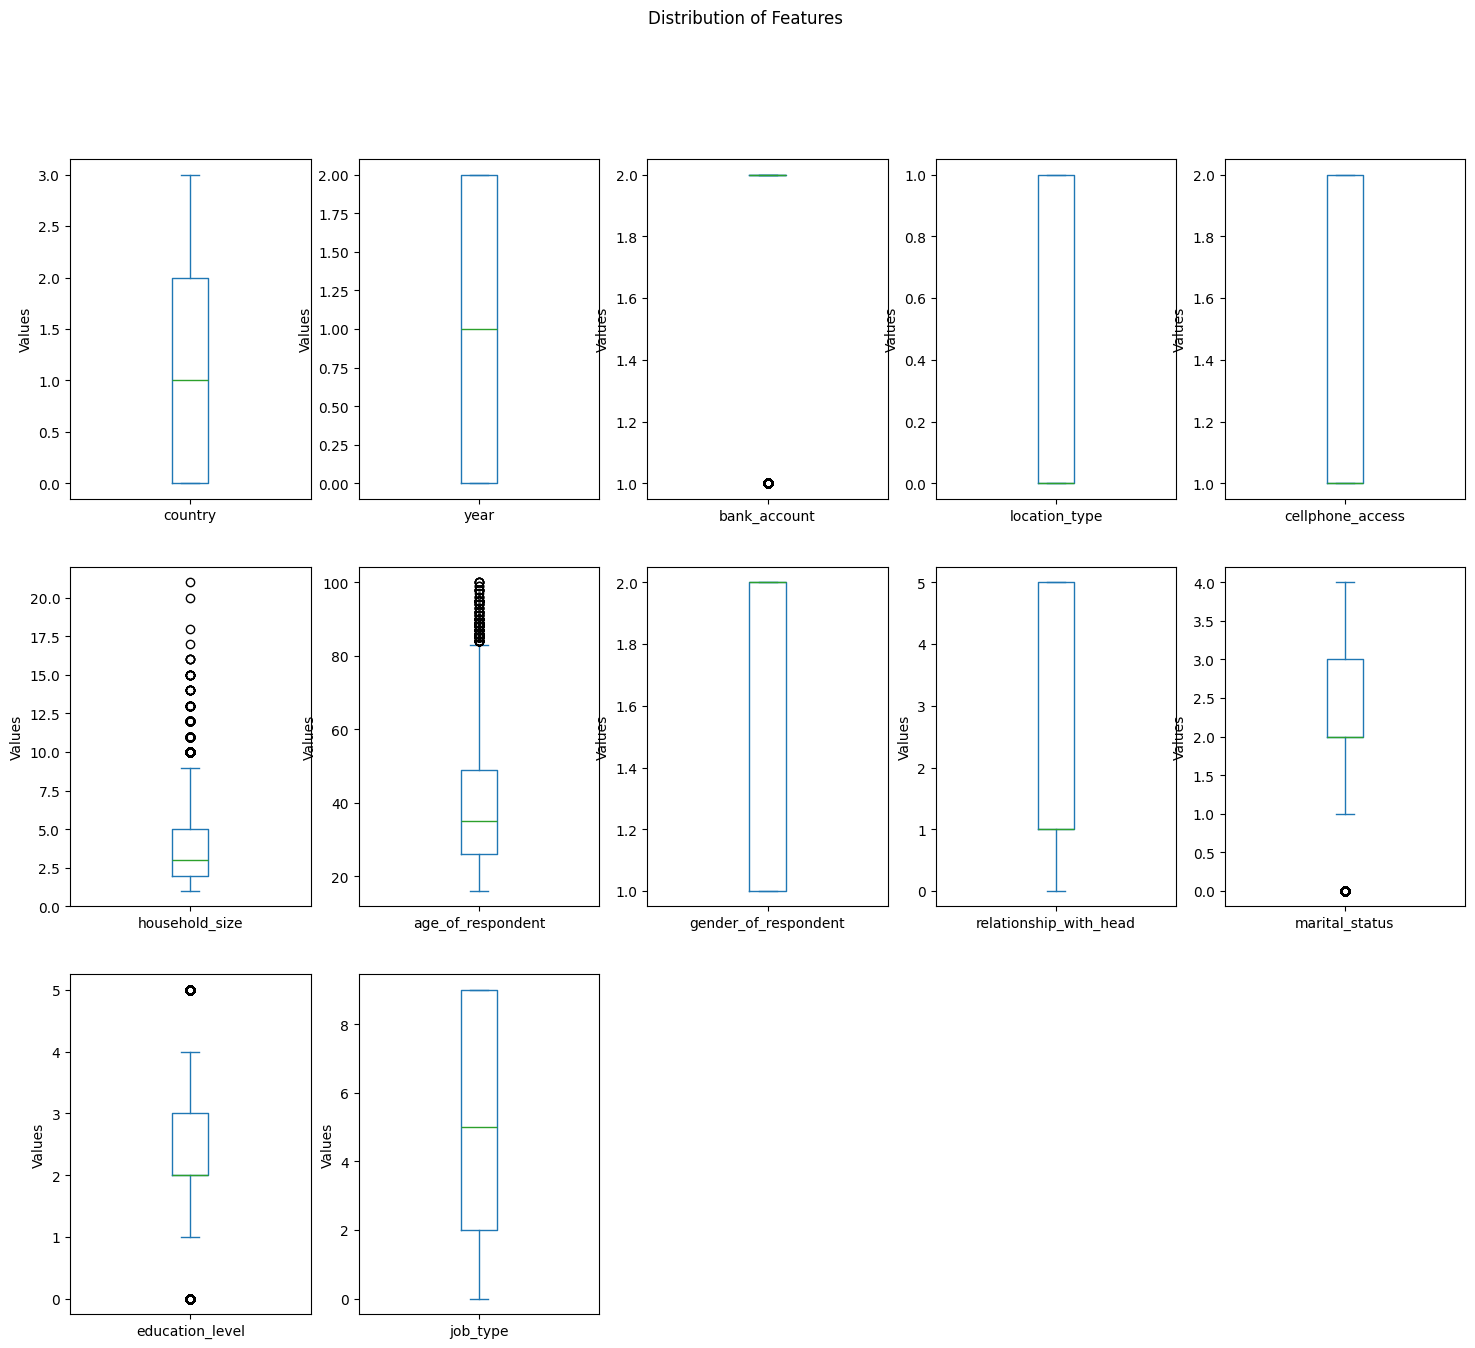

In [29]:
finance_df.plot(kind = 'box', subplots = True, figsize = (18,15), layout = (3,5), ylabel = 'Values', title = 'Distribution of Features')
plt.show()

In [30]:
# Let's handle outliers for the household size, age of respondent, marital status
outlier_cols = ['household_size', 'age_of_respondent', 'marital_status', 'education_level']

### Feature Selection

#### Generating correlation matrix
This will help us define the features we want to use for our prediction

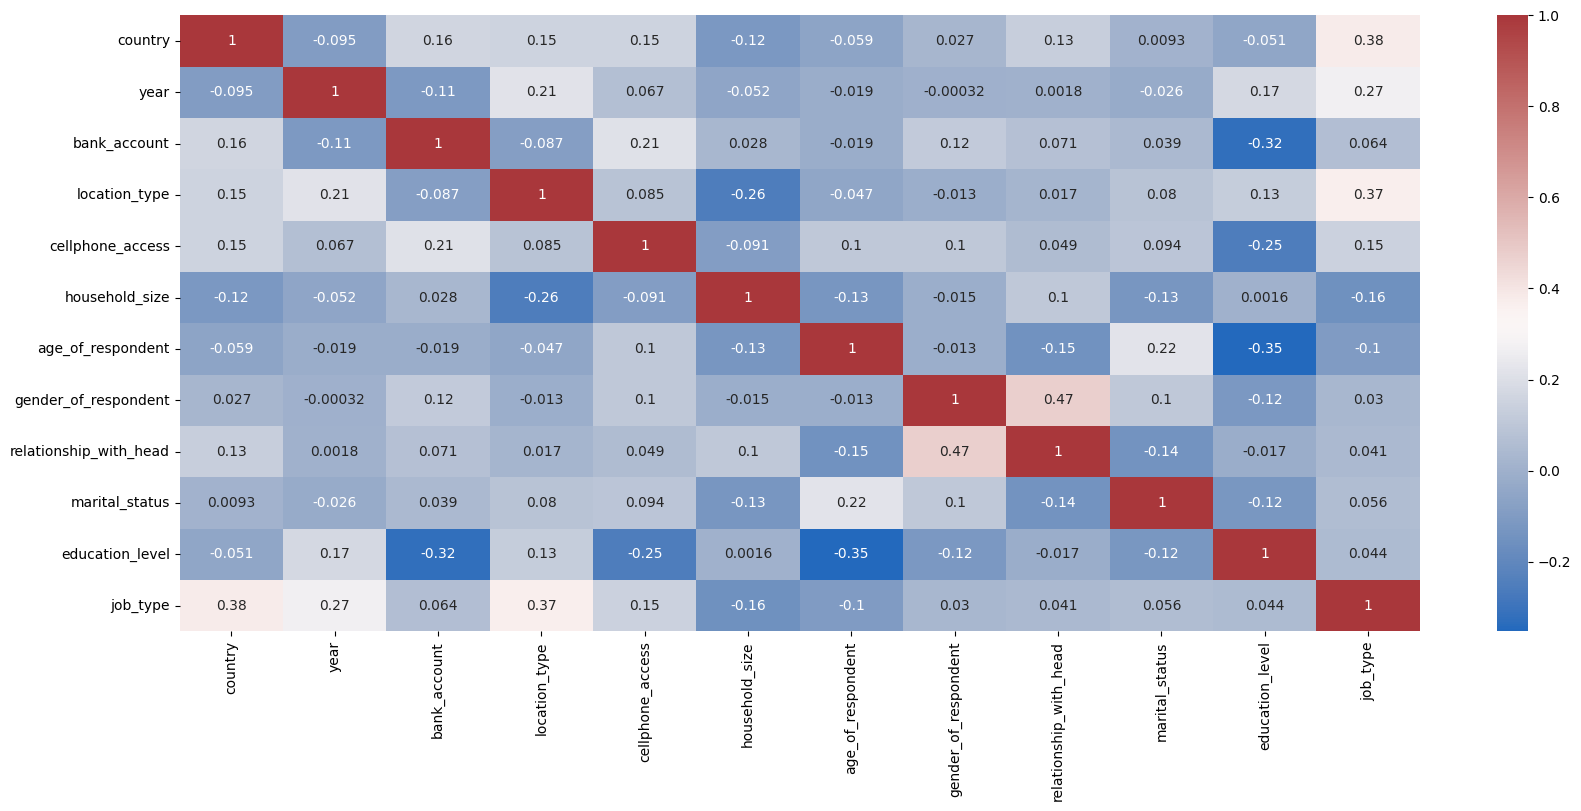

In [31]:
plt.figure(figsize=(20,8))
sns.heatmap(data=finance_df.drop('uniqueid', axis=1).corr(), annot=True, cmap='vlag')
plt.show()

* The education level has a negative correlation to the bank account meaning that people with lack or low levels with education are most likely not going to have a bank account
* Cell phone access has a positive correlation of 0.21 to people owning bank accounts, together with the country they belong to (0.16). This indicates that the country and cell phone access play a big role to owning a bank account
* The gender also has a positive albeit weak correlation to owning a bank account.
* Due to domain knowledge, the job type and age of respondent might also affect whether one owns a bank account or not given the former can be either blue or white collar and the people with lower age in the latter might not own a bank account
* Given the information above, we can select the education_level, cellphone_access, country and gender_of_respondents as the features to use for our predictions. We can adjust accordingly to enhance the performance of our model. 

### Training our model

In [32]:
# Feature selection
X = finance_df[['education_level', 'gender_of_respondent', 'job_type', 'age_of_respondent', 'cellphone_access', 'country']]
y = finance_df['bank_account']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
# We'll train our model using RandomForest Classifier since it's not prown to outliers
cls = RandomForestClassifier()
cls.fit(X_train, y_train)

RandomForestClassifier()

In [35]:
y_pred = cls.predict(X_test)

#### Evaluating our model

In [36]:
# Checking actual vs prediction values
pred_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
pred_df.head(15)

,Actual,Predicted
6692,2,2
7628,2,2
10873,2,2
19704,2,2
7047,2,2
13110,2,2
6061,2,1
2229,2,1
5277,1,2
9097,1,2


In [37]:
# Mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(mae)

0.13573250212524796


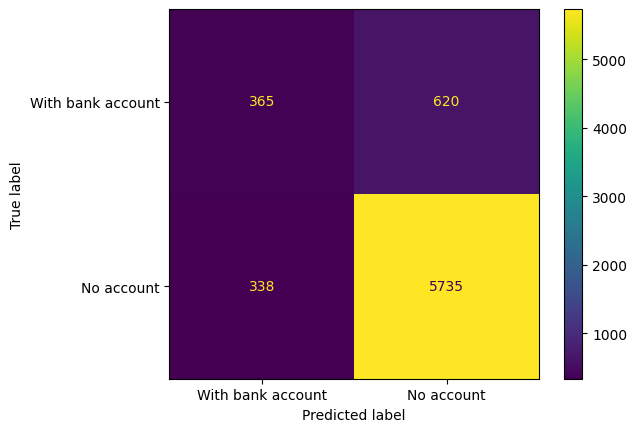

In [38]:
# Confusion matrix
cmx = confusion_matrix(y_test, y_pred)
#ConfusionMatrixDisplay(confusion_matrix = cmx, display_labels = [0, 1]).plot()
disp = ConfusionMatrixDisplay(confusion_matrix=cmx, display_labels=['With bank account', 'No account'])
disp.plot()

In [39]:
# Classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           1       0.52      0.37      0.43       985
           2       0.90      0.94      0.92      6073

    accuracy                           0.86      7058
   macro avg       0.71      0.66      0.68      7058
weighted avg       0.85      0.86      0.85      7058



Judging on the evaluation, the f1 score is 0.44 hence there is room for improvement. We can use hyperparemeter tuning to improve the model

### Saving our model

In [40]:
joblib.dump(cls, 'joblib-files/rm-model.joblib')

['joblib-files/rm-model.joblib']